### R 프로그래밍을 통한 SparkML 예제입니다. 

몇가지 널리 알려진 데이터셋 (iris, mtcars)을 통해 sparkML 알고리즘을 활용하여 분석 결과를 얻어내는 실습입니다. 


In [1]:
library(sparklyr)

In [2]:
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
sc <- spark_connect(master = "local")

In [43]:
iris_tbl <- copy_to(sc, iris, "iris", overwrite = TRUE)
head(iris_tbl, 10)

# Source: spark<?> [?? x 5]
   Sepal_Length Sepal_Width Petal_Length Petal_Width Species
 *        <dbl>       <dbl>        <dbl>       <dbl> <chr>  
 1          5.1         3.5          1.4         0.2 setosa 
 2          4.9         3            1.4         0.2 setosa 
 3          4.7         3.2          1.3         0.2 setosa 
 4          4.6         3.1          1.5         0.2 setosa 
 5          5           3.6          1.4         0.2 setosa 
 6          5.4         3.9          1.7         0.4 setosa 
 7          4.6         3.4          1.4         0.3 setosa 
 8          5           3.4          1.5         0.2 setosa 
 9          4.4         2.9          1.4         0.2 setosa 
10          4.9         3.1          1.5         0.1 setosa 
# ... with more rows

### K-MEANS CLUSTERING
Use Spark’s K-means clustering to partition a dataset into groups. K-means clustering partitions points into k groups, such that the sum of squares from points to the assigned cluster centers is minimized.

In [86]:
 kmeans_model <- iris_tbl %>%
  select(Petal_Width, Petal_Length) %>%
  ml_kmeans(k = 3, features = c("Petal_Length","Petal_Width"))

In [88]:
# print our model fit
kmeans_model

K-means clustering with 3 clusters

Cluster centers:
  Petal_Length Petal_Width
1     4.292593    1.359259
2     1.462000    0.246000
3     5.626087    2.047826

Within Set Sum of Squared Errors =  31.41289

In [89]:
kmeans_model$centers

Petal_Length,Petal_Width
4.292593,1.359259
1.462000,0.246000
5.626087,2.047826


In [90]:
# predict the associated class
predicted <- ml_predict(kmeans_model, iris_tbl) %>% collect 

In [91]:
table(predicted$Species, predicted$prediction)

            
              0  1  2
  setosa      0 50  0
  versicolor 48  0  2
  virginica   6  0 44

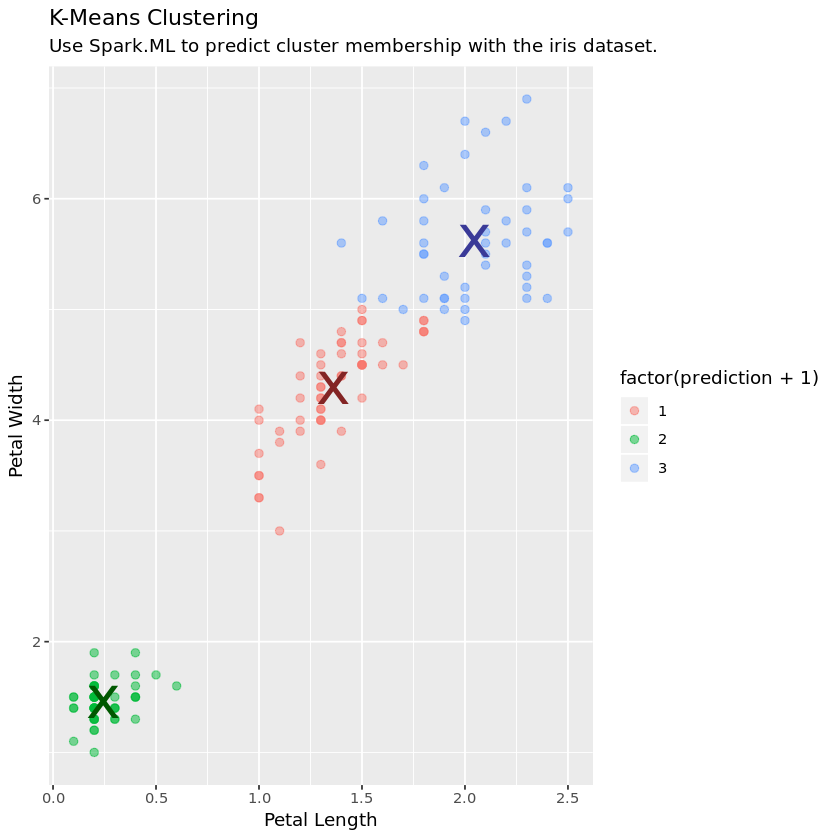

In [93]:
# plot cluster membership

ggplot(predicted, aes(Petal_Length, Petal_Width)) + 
geom_point(aes(Petal_Width, Petal_Length, col = factor(prediction + 1)),size = 2, alpha = 0.5) +
geom_point(data = kmeans_model$centers, aes(Petal_Width, Petal_Length),
             col = scales::muted(c("red", "green", "blue")),
             pch = 'x', size = 12) +
labs(
    x = "Petal Length",
    y = "Petal Width",
    title = "K-Means Clustering",
    subtitle = "Use Spark.ML to predict cluster membership with the iris dataset."
  )


### LINEAR REGRESSION
Use Spark’s linear regression to model the linear relationship between a response variable and one or more explanatory variables.

In [94]:
lm_model <- iris_tbl %>%
  select(Petal_Width, Petal_Length) %>%
  ml_linear_regression(Petal_Length ~ Petal_Width)

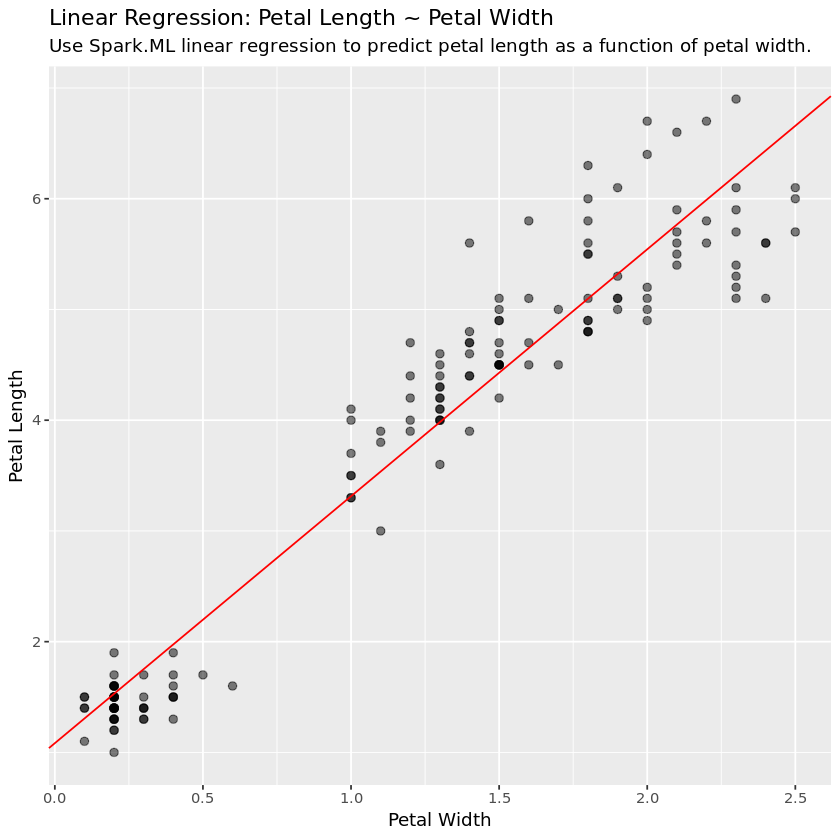

In [95]:
iris_tbl %>%
  select(Petal_Width, Petal_Length) %>%
  collect %>%
  ggplot(aes(Petal_Length, Petal_Width)) +
    geom_point(aes(Petal_Width, Petal_Length), size = 2, alpha = 0.5) +
    geom_abline(aes(slope = coef(lm_model)[["Petal_Width"]],
                    intercept = coef(lm_model)[["(Intercept)"]]),
                color = "red") +
  labs(
    x = "Petal Width",
    y = "Petal Length",
    title = "Linear Regression: Petal Length ~ Petal Width",
    subtitle = "Use Spark.ML linear regression to predict petal length as a function of petal width."
  )

### PCA
Use Spark’s Principal Components Analysis (PCA) to perform dimensionality reduction. PCA is a statistical method to find a rotation such that the first coordinate has the largest variance possible, and each succeeding coordinate in turn has the largest variance possible.

In [96]:
pca_model <- tbl(sc, "iris") %>%
  select(-Species) %>%
  ml_pca()

In [97]:
print(pca_model)

Explained variance:

        PC1         PC2         PC3         PC4 
0.924618723 0.053066483 0.017102610 0.005212184 

Rotation:
                     PC1         PC2         PC3        PC4
Sepal_Length -0.36138659 -0.65658877  0.58202985  0.3154872
Sepal_Width   0.08452251 -0.73016143 -0.59791083 -0.3197231
Petal_Length -0.85667061  0.17337266 -0.07623608 -0.4798390
Petal_Width  -0.35828920  0.07548102 -0.54583143  0.7536574


### RANDOM FOREST
Use Spark’s Random Forest to perform regression or multiclass classification.

In [99]:
rf_model <- iris_tbl %>%
  ml_random_forest(Species ~ Petal_Length + Petal_Width, type = "classification")

In [101]:
rf_predict <- ml_predict(rf_model, iris_tbl) %>%
  ft_string_indexer("Species", "Species_idx") %>%
  collect

table(rf_predict$Species_idx, rf_predict$prediction)

   
     0  1  2
  0 49  1  0
  1  0 50  0
  2  0  0 50

### SDF PARTITIONING
Split a Spark DataFrame into training, test datasets.

In [107]:
partitions <- tbl(sc, "iris") %>%
  sdf_random_split(training = 0.75, test = 0.25)

fit <- partitions$training %>%
  ml_linear_regression(Petal_Length ~ Petal_Width)

In [109]:
estimate_mse <- function(df){
  ml_predict(fit, df) %>%
  mutate(resid = Petal_Length - prediction) %>%
  summarize(mse = mean(resid ^ 2)) %>%
  collect
}

sapply(partitions, estimate_mse)

Warning message:
“Missing values are always removed in SQL.
Use `AVG(x, na.rm = TRUE)` to silence this warning”Warning message:
“Missing values are always removed in SQL.
Use `AVG(x, na.rm = TRUE)` to silence this warning”Warning message:
“Missing values are always removed in SQL.
Use `AVG(x, na.rm = TRUE)` to silence this warning”Warning message:
“Missing values are always removed in SQL.
Use `AVG(x, na.rm = TRUE)` to silence this warning”

$training.mse
[1] 0.2333537

$test.mse
[1] 0.2048797